This notebbook evaluates the active rate of elements with different features across LentiMPRA, ATAC-STARR-seq and WHG-STARR-seq datasets using the uniformly processed results and produces key results in Figure 5. 

Before running the analysis in this script, you need to run 5_prepare_reference_data.py and 6_annotate_uniform_processed_calls.py first to obtain transcriptional levels and overlap extent with cCREs and GRO-cap elements for regions tested in each assay. 

In [1]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/') 


In [2]:
def compute_active_rate_summary(df):
    """
    Compute active/inactive region counts and active rate from a DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        Subset DataFrame of tested regions with a 'call' column.

    Returns:
    -------
    Tuple[int, int, int, float]
        - num_active: Number of active regions
        - num_inactive: Number of inactive regions
        - num_total: Total number of regions
        - active_rate: Percentage of active regions among total (0–100)
    """
    num_total = len(df)

    if num_total > 0:
        num_active = len(df[df['call'] == 'active'])
        num_inactive = len(df[df['call'] == 'inactive'])
        active_rate = num_active / num_total * 100
    else:
        num_active = 0
        num_inactive = 0
        active_rate = 0.0

    return num_active, num_inactive, num_total, active_rate


def calculate_active_region_stats(data, category_col, category_value):
    """
    Calculate activity statistics (active, inactive, and total counts) for a specific category.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing a 'call' column indicating whether a region is 'active' or 'inactive',
        along with a categorical column to group by (e.g., 'promoter_1kb_tss', 'divergent', etc.).

    category_col : str
        The name of the column containing category labels to subset the data.

    category_value : str
        The specific category value within `category_col` to calculate statistics for.

    Returns:
    --------
    tuple : (int, int, int, float)
        - Number of active regions
        - Number of inactive regions
        - Total number of regions
        - Percentage of active regions (0–100%)
    """

    subset = data[data[category_col] == category_value]
    return compute_active_rate_summary(subset)


def format_annotation_text(row):
    """
    Format text annotation for active rate display.

    Given a row from a DataFrame that includes the number of active and total regions,
    this function returns a string in the format:
        "X,XXX/Y,YYY (Z%)"
    where:
        - X,XXX is the number of active regions (with comma formatting)
        - Y,YYY is the total number of regions (with comma formatting)
        - Z% is the active rate percentage, rounded to:
            - 1 decimal place if < 1%
            - nearest integer if ≥ 1%

    Parameters:
    -----------
    row : pd.Series
        A row from a DataFrame containing 'num_active', 'num_total', and 'active_rate' columns.

    Returns:
    --------
    str
        Formatted string annotation.
    """
    # Extract values from the row
    active = row['num_active']
    total = row['num_total']
    rate = row['active_rate']

    # Format percentage: 1 decimal if <1%, otherwise round to whole number
    if rate < 1:
        percent_str = f"{rate:.1f}%"
    else:
        percent_str = f"{round(rate):.0f}%"

    # Format string: "X,XXX/Y,YYY (Z%)"
    return f"{active:,}/{total:,} ({percent_str})"


In [3]:
def barplot(
    data,
    x_col,
    y_col,
    hue_col,
    hue_order,
    x_order,
    palette,
    xlabel,
    ylabel,
    x_tick_labels,
    out_path='',
    rotation=30
):
    """
    Create a grouped bar plot with percentage annotations for each bar.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe containing plotting data.

    x_col : str
        Column name in `data` to be used for x-axis categories.

    y_col : str
        Column name in `data` to be used for bar heights (typically a percentage).

    hue_col : str
        Column name in `data` to group bars by color.

    hue_order : list of str
        Desired order of hue groups (legend order and grouped bars).

    x_order : list of str
        Desired order of x-axis categories.

    palette : dict or list
        Color palette to use for the bars (mapping hue values to colors).

    xlabel : str
        Label for the x-axis.

    ylabel : str
        Label for the y-axis.

    x_tick_labels : list of str
        Custom x-axis tick labels (displayed instead of x_order).

    out_path : str, optional
        If provided, saves the plot to this file path.

    rotation : int, optional
        Degree of rotation for x-axis tick labels. Default is 30.
    """

    # Initialize plot canvas
    fig = plt.figure(figsize=(len(x_order), 3))
    
    # Draw barplot using seaborn
    ax = sns.barplot(
        data=data,
        x=x_col,
        y=y_col,
        hue=hue_col,
        hue_order=hue_order,
        order=x_order,
        width=0.8,
        errorbar=None,
        palette=palette
    )

    # Set axis labels and limits
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_ylim([0, 100])

    # Format x-tick labels
    ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)

    # Format y-tick labels as percentages
    y_ticks = ax.get_yticks().tolist()
    y_tick_labels = [f"{round(tick)}%" for tick in y_ticks]
    ax.set_yticklabels(y_tick_labels, fontsize=17)

    # Remove chart border
    sns.despine()

    # Collect text labels for annotation
    bar_labels = []
    for hue_val in hue_order:
        for x_val in x_order:
            subset_df = data[(data[x_col] == x_val) & (data[hue_col] == hue_val)]
            bar_labels.append(subset_df['text'].tolist()[0])

    # Annotate bars
    bars = ax.patches
    for bar, label in zip(bars, bar_labels):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            100,  # Top of the plot
            label,
            ha='center',
            va='top',
            rotation=90,
            fontsize=15
        )

    # Format legend
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fancybox=True,
        ncol=1,
        borderaxespad=0.,
        fontsize=15
    )

    # Save to file if path is given
    if out_path != '':
        plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)
        

In [4]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)


/local/storage/jz855/STARR_seq_code/Final_Code_Sharing


In [5]:
# Columns

columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

print(len(columns))


52


In [6]:
# Load dataset, orientation-independent calls

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'LentiMPRA', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
lentimpra = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(lentimpra))
lentimpra.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'ATAC_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
atac_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(atac_starr))
atac_starr.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'WHG_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
whg_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(whg_starr))
whg_starr.columns = columns



109506
304682
1622172


# Analyze Active Rates Across Transcription Classes and Datasets

In [7]:
# ----------------------------------------------
# Analyze Active Rates Across Transcription Classes and Datasets
# ----------------------------------------------

# Define column for transcription classes and categories to evaluate
transcription_class_col = 'separate_GROcap_signal_levels'
transcription_classes = ['none_transcription', 'low_transcription', 'medium_transcription', 'high_transcription']

# Container for data across datasets
all_stats_by_dataset = []

# Iterate through each dataset
for dataset_df, dataset_name in zip([whg_starr, atac_starr, lentimpra], 
                                    ['WHG-STARR-seq', 'ATAC-STARR-seq', 'LentiMPRA']):

    dataset_stats_rows = []

    for transcription_class in transcription_classes:
        num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
            dataset_df, transcription_class_col, transcription_class
        )

        dataset_stats_rows.append((
            dataset_name, transcription_class_col, transcription_class,
            num_active, num_inactive, num_total, active_rate
        ))

    dataset_stats_df = pd.DataFrame(
        dataset_stats_rows,
        columns=[
            'dataset', 'category_col', 'category_value',
            'num_active', 'num_inactive', 'num_total', 'active_rate'
        ]
    )

    all_stats_by_dataset.append(dataset_stats_df)

# Combine all dataset-level stats
combined_stats_df = pd.concat(all_stats_by_dataset, axis=0, ignore_index=True)

# ----------------------------------------------
# Format annotation text: "active/total (X%)"
# - Use commas in integers
# - Round percentage: 1 decimal if <1%, else no decimals
# ----------------------------------------------

combined_stats_df['text'] = combined_stats_df.apply(format_annotation_text, axis=1)

# Final output preview
# print(combined_stats_df.head())


<ipython-input-3-fe5b2e54a2d6>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-3-fe5b2e54a2d6>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels, fontsize=17)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


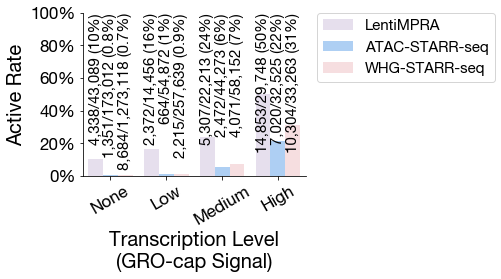

In [8]:
# -----------------------------
# Setup for Active Rate Barplot
# -----------------------------

# Order of datasets for hue grouping (legend and bar colors)
dataset_order_list = ['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# X-axis tick labels for plot display
x_tick_labels = ['None', 'Low', 'Medium', 'High']

# Internal order of transcription categories (used for x-axis positioning)
x_order_list = ['none_transcription', 'low_transcription', 'medium_transcription', 'high_transcription']

# Define color palette for each dataset
palette = {
    'LentiMPRA': '#e6ddef',
    'ATAC-STARR-seq': '#a2cffe',
    'WHG-STARR-seq': '#fadadd'
}


# Output file path for saved figure
out_path = os.path.join(project_root, 'plot', 'active_rate', 
                        'active_rate_across_all_transcription_level_class.pdf')

# -----------------------------------------
# Generate Barplot of Active Rate by Signal
# -----------------------------------------
barplot(
    data=combined_stats_df,
    x_col='category_value',         # Column for x-axis categories
    y_col='active_rate',            # Column for bar heights
    hue_col='dataset',              # Column used for grouping (colors)
    hue_order=dataset_order_list,   # Order of groups in legend
    x_order=x_order_list,           # Order of x-axis categories
    palette=palette,                # Color palette for bars
    xlabel='Transcription Level\n(GRO-cap Signal)', 
    ylabel='Active Rate', 
    x_tick_labels=x_tick_labels,    # Labels shown on the x-axis
    out_path=out_path,              # File to save the figure
    rotation=30                     # Rotation angle for x-tick labels
)


In [9]:
def remove_redundant_ccre_overlap(dataset_df):
    """
    Removes redundant overlapping cCRE entries from the input DataFrame.
    Keeps only the entry with the largest cCRE overlap (bp) per unique cCRE.

    Parameters:
    ----------
    dataset_df : pd.DataFrame
        Annotated MPRA dataset with cCRE overlap information.

    Returns:
    -------
    pd.DataFrame
        Updated DataFrame with redundant cCRE overlaps removed.
    """
    # Split entries into those that do and do not overlap a cCRE
    non_overlapping_df = dataset_df[dataset_df['ccre_overlap_bp'] == 0]
    overlapping_df = dataset_df[dataset_df['ccre_overlap_bp'] > 0]

    print(f"Non-overlapping entries: {len(non_overlapping_df)}")
    print(f"Overlapping entries: {len(overlapping_df)}")
    print(f"Total entries: {len(dataset_df)}")

    # Among overlapping entries, keep only the row with the largest overlap for each cCRE
    overlapping_df = overlapping_df.sort_values('ccre_overlap_bp', ascending=False)
    overlapping_df = overlapping_df.drop_duplicates('ccre_name')

    print(f"Deduplicated overlapping entries: {len(overlapping_df)}")

    # Combine cleaned overlapping and non-overlapping entries
    cleaned_df = pd.concat([overlapping_df, non_overlapping_df], axis=0, ignore_index=True)
    print(f"Total after deduplication: {len(cleaned_df)}")

    # Summary of overlap status
    print("Before deduplication:")
    print(dataset_df.groupby('not_overlap_cCRE').size())

    print("After deduplication:")
    print(cleaned_df.groupby('not_overlap_cCRE').size())
    print('-----------------------')

    return cleaned_df


# Apply to each dataset
whg_starr_dedup = remove_redundant_ccre_overlap(whg_starr)
atac_starr_dedup = remove_redundant_ccre_overlap(atac_starr)
lentimpra_dedup = remove_redundant_ccre_overlap(lentimpra)


Non-overlapping entries: 713883
Overlapping entries: 908289
Total entries: 1622172
Deduplicated overlapping entries: 877919
Total after deduplication: 1591802
Before deduplication:
not_overlap_cCRE
.                   908289
not_overlap_cCRE    713883
dtype: int64
After deduplication:
not_overlap_cCRE
.                   877919
not_overlap_cCRE    713883
dtype: int64
-----------------------
Non-overlapping entries: 62222
Overlapping entries: 242460
Total entries: 304682
Deduplicated overlapping entries: 222019
Total after deduplication: 284241
Before deduplication:
not_overlap_cCRE
.                   242460
not_overlap_cCRE     62222
dtype: int64
After deduplication:
not_overlap_cCRE
.                   222019
not_overlap_cCRE     62222
dtype: int64
-----------------------
Non-overlapping entries: 8044
Overlapping entries: 101462
Total entries: 109506
Deduplicated overlapping entries: 99554
Total after deduplication: 107598
Before deduplication:
not_overlap_cCRE
.                   10

# Analyze Active Rates for Specific Regulatory Categories Across Three Datasets

In [10]:
# ------------------------------------------------------
# Compute active rates for specific regulatory categories
# across WHG-STARR-seq, ATAC-STARR-seq, and LentiMPRA
# ------------------------------------------------------

# Initialize list to store summary tuples
summary_stats = []

# Loop through each dataset and its label
for dataset_df, dataset_name in zip(
    [whg_starr_dedup, atac_starr_dedup, lentimpra_dedup], 
    ['WHG-STARR-seq', 'ATAC-STARR-seq', 'LentiMPRA']
):
    # (1) Untranscribed and does not overlap any GRO-cap or cCRE
    subset = dataset_df[
        (dataset_df['binary_transcription_class'] == 'not_transcribed') &
        (dataset_df['not_overlap_GROcap_elements'] == 'not_overlap_GROcap_elements') &
        (dataset_df['not_overlap_cCRE'] == 'not_overlap_cCRE')
    ]
    stats = compute_active_rate_summary(subset)
    summary_stats.append((dataset_name, 'untranscribed_no_overlap_PINTS_no_overlap_cCRE', *stats))

    # (2) Untranscribed with high-overlap cCRE (≥80% both ways)
    subset = dataset_df[
        (dataset_df['binary_transcription_class'] == 'not_transcribed') &
        (dataset_df['ccre_overlap_pct_region'] >= 80) &
        (dataset_df['ccre_overlap_pct_ccre'] >= 80)
    ]
    stats = compute_active_rate_summary(subset)
    summary_stats.append((dataset_name, 'untranscribed_high_overlap_cCRE', *stats))

    # (3) Untranscribed with high-overlap ELS/PLS elements
    subset = dataset_df[
        (dataset_df['binary_transcription_class'] == 'not_transcribed') &
        (dataset_df['ELS_PLS'] == 'high')
    ]
    stats = compute_active_rate_summary(subset)
    summary_stats.append((dataset_name, 'untranscribed_high_overlap_ELS_PLS', *stats))

    # (4) Transcribed with high-overlap cCRE (≥80% both ways)
    subset = dataset_df[
        (dataset_df['binary_transcription_class'] == 'transcribed') &
        (dataset_df['ccre_overlap_pct_region'] >= 80) &
        (dataset_df['ccre_overlap_pct_ccre'] >= 80)
    ]
    stats = compute_active_rate_summary(subset)
    summary_stats.append((dataset_name, 'transcribed_high_overlap_cCRE', *stats))

    # (5) Transcribed with high-overlap ELS/PLS elements
    subset = dataset_df[
        (dataset_df['binary_transcription_class'] == 'transcribed') &
        (dataset_df['ELS_PLS'] == 'high')
    ]
    stats = compute_active_rate_summary(subset)
    summary_stats.append((dataset_name, 'transcribed_high_overlap_ELS_PLS', *stats))

# Create final summary DataFrame
summary_df = pd.DataFrame(
    summary_stats,
    columns=['dataset', 'category', 'num_active', 'num_inactive', 'num_total', 'active_rate']
)

# Generate formatted text annotations (e.g., 2,234/257,698 (0.9%))
summary_df['text'] = summary_df.apply(format_annotation_text, axis=1)

# Display summary table
print(summary_df.head())


         dataset                                        category  num_active   
0  WHG-STARR-seq  untranscribed_no_overlap_PINTS_no_overlap_cCRE        2174  \
1  WHG-STARR-seq                 untranscribed_high_overlap_cCRE         409   
2  WHG-STARR-seq              untranscribed_high_overlap_ELS_PLS           0   
3  WHG-STARR-seq                   transcribed_high_overlap_cCRE        1686   
4  WHG-STARR-seq                transcribed_high_overlap_ELS_PLS        1038   

   num_inactive  num_total  active_rate                  text  
0        647129     649303     0.334821  2,174/649,303 (0.3%)  
1         18692      19101     2.141249       409/19,101 (2%)  
2             8          8     0.000000            0/8 (0.0%)  
3          4232       5918    28.489355     1,686/5,918 (28%)  
4           561       1599    64.915572     1,038/1,599 (65%)  


<ipython-input-3-fe5b2e54a2d6>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-3-fe5b2e54a2d6>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels, fontsize=17)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


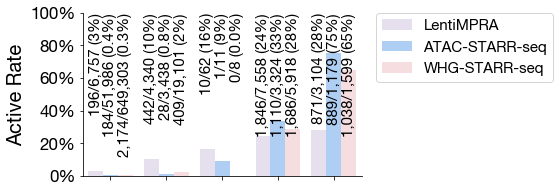

In [11]:
# -----------------------------
# Setup for Active Rate Barplot
# -----------------------------

# Order of datasets for hue grouping (legend and bar colors)
dataset_order_list = ['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# X-axis tick labels for plot display
x_tick_labels = ['', '', '', '', '']

# Internal order of transcription categories (used for x-axis positioning)
x_order_list = ['untranscribed_no_overlap_PINTS_no_overlap_cCRE', 
                'untranscribed_high_overlap_cCRE', 
                'untranscribed_high_overlap_ELS_PLS', 
                'transcribed_high_overlap_cCRE', 
                'transcribed_high_overlap_ELS_PLS']

# Define color palette for each dataset
palette = {
    'LentiMPRA': '#e6ddef',
    'ATAC-STARR-seq': '#a2cffe',
    'WHG-STARR-seq': '#fadadd'
}


# Output file path for saved figure
out_path = os.path.join(project_root, 'plot', 'active_rate', 
                        'active_rate_of_high_overlap_cCREs_comparing_transcribed_vs_untranscribed.pdf')

# -----------------------------------------
# Generate Barplot of Active Rate by Signal
# -----------------------------------------
barplot(
    data=summary_df,
    x_col='category',               # Column for x-axis categories
    y_col='active_rate',            # Column for bar heights
    hue_col='dataset',              # Column used for grouping (colors)
    hue_order=dataset_order_list,   # Order of groups in legend
    x_order=x_order_list,           # Order of x-axis categories
    palette=palette,                # Color palette for bars
    xlabel='', 
    ylabel='Active Rate', 
    x_tick_labels=x_tick_labels,    # Labels shown on the x-axis
    out_path=out_path,              # File to save the figure
    rotation=30                     # Rotation angle for x-tick labels
)


# Analyze Active Rates Stratified by GRO-cap Signal within High-Overlap ELS/PLS cCREs Across Three Datasets

In [12]:
# -------------------------------------------------------------
# Analyze Active Rates Stratified by GRO-cap Signal
# within High-Overlap ELS/PLS cCREs Across Three Datasets
# -------------------------------------------------------------

# Column that defines transcriptional activity classification
transcription_class_column = 'separate_GROcap_signal_levels'

# Define transcription classes of interest (based on GRO-cap signal)
transcription_class_list = [
    'none_transcription',
    'low_transcription',
    'medium_transcription',
    'high_transcription'
]

# Column indicating strong cCRE overlap with ELS or PLS
ccre_overlap_class_column = 'ELS_PLS'

# Initialize container to collect stats from all datasets
combined_summary_by_dataset = []

# ----------------------------------------------
# Loop through each dataset to calculate stats
# ----------------------------------------------
for df_dataset, dataset_label in zip(
    [whg_starr, atac_starr, lentimpra],
    ['WHG-STARR-seq', 'ATAC-STARR-seq', 'LentiMPRA']
):

    per_dataset_rows = []

    # Subset to regions with high-overlap ELS/PLS cCREs
    subset_df = df_dataset[df_dataset[ccre_overlap_class_column] == 'high']

    # Iterate over transcription classes and calculate stats
    for transcription_class in transcription_class_list:
        num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
            subset_df, transcription_class_column, transcription_class
        )

        per_dataset_rows.append((
            dataset_label,
            transcription_class_column,
            transcription_class,
            num_active,
            num_inactive,
            num_total,
            active_rate
        ))

    # Convert current dataset results into a DataFrame
    per_dataset_df = pd.DataFrame(
        per_dataset_rows,
        columns=[
            'dataset', 'category_col', 'category_value',
            'num_active', 'num_inactive', 'num_total', 'active_rate'
        ]
    )

    # Add to global summary
    combined_summary_by_dataset.append(per_dataset_df)

# ----------------------------------------------
# Combine all per-dataset DataFrames into one
# ----------------------------------------------
summary_df = pd.concat(combined_summary_by_dataset, axis=0, ignore_index=True)

# ----------------------------------------------
# Generate annotation text in the form: 2,234/257,698 (0.9%)
# ----------------------------------------------
summary_df['text'] = summary_df.apply(format_annotation_text, axis=1)

# Optional: preview the result
print(summary_df.head())


          dataset                   category_col        category_value   
0   WHG-STARR-seq  separate_GROcap_signal_levels    none_transcription  \
1   WHG-STARR-seq  separate_GROcap_signal_levels     low_transcription   
2   WHG-STARR-seq  separate_GROcap_signal_levels  medium_transcription   
3   WHG-STARR-seq  separate_GROcap_signal_levels    high_transcription   
4  ATAC-STARR-seq  separate_GROcap_signal_levels    none_transcription   

   num_active  num_inactive  num_total  active_rate             text  
0           0             8          8     0.000000       0/8 (0.0%)  
1           5            22         27    18.518519       5/27 (19%)  
2          66           190        256    25.781250     66/256 (26%)  
3         967           349       1316    73.480243  967/1,316 (73%)  
4           1            10         11     9.090909        1/11 (9%)  


<ipython-input-3-fe5b2e54a2d6>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-3-fe5b2e54a2d6>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels, fontsize=17)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


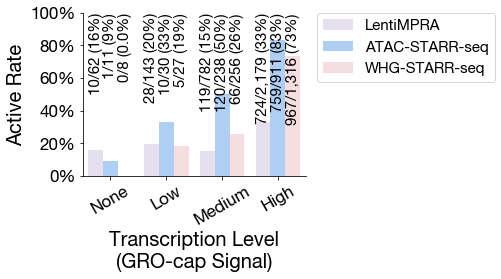

In [13]:
# -----------------------------
# Setup for Active Rate Barplot
# -----------------------------

# Order of datasets for hue grouping (legend and bar colors)
dataset_order_list = ['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# X-axis tick labels for plot display
x_tick_labels = ['None', 'Low', 'Medium', 'High']

# Internal order of transcription categories (used for x-axis positioning)
x_order_list = ['none_transcription', 'low_transcription', 'medium_transcription', 'high_transcription']

# Define color palette for each dataset
palette = {
    'LentiMPRA': '#e6ddef',
    'ATAC-STARR-seq': '#a2cffe',
    'WHG-STARR-seq': '#fadadd'
}


# Output file path for saved figure
out_path = os.path.join(project_root, 'plot', 'active_rate', 
                        'active_rate_across_all_transcription_level_class_of_high_overlap_ELS_PLS.pdf')

# -----------------------------------------
# Generate Barplot of Active Rate by Signal
# -----------------------------------------
barplot(
    data=summary_df,
    x_col='category_value',         # Column for x-axis categories
    y_col='active_rate',            # Column for bar heights
    hue_col='dataset',              # Column used for grouping (colors)
    hue_order=dataset_order_list,   # Order of groups in legend
    x_order=x_order_list,           # Order of x-axis categories
    palette=palette,                # Color palette for bars
    xlabel='Transcription Level\n(GRO-cap Signal)', 
    ylabel='Active Rate', 
    x_tick_labels=x_tick_labels,    # Labels shown on the x-axis
    out_path=out_path,              # File to save the figure
    rotation=30                     # Rotation angle for x-tick labels
)


# compare effect size of LentiMPRA identified enhancers with different transcription levels

In [14]:
columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

In [22]:
tmp = lentimpra_dedup[['logFC', 'separate_GROcap_signal_levels', 'call']]
tmp = tmp[tmp['call'] == 'active']
tmp["logFC"] = tmp["logFC"].astype(float)
tmp


,logFC,separate_GROcap_signal_levels,call
7,1.261948,low_transcription,active
13,1.465155,high_transcription,active
18,1.301563,high_transcription,active
20,1.113151,high_transcription,active
26,1.152911,high_transcription,active
...,...,...,...
107330,1.696310,medium_transcription,active
107340,1.701058,high_transcription,active
107442,1.190341,low_transcription,active
107458,0.667093,low_transcription,active


In [16]:
tmp['separate_GROcap_signal_levels'].value_counts()

separate_GROcap_signal_levels
high_transcription      14692
medium_transcription     5256
none_transcription       4307
low_transcription        2349
Name: count, dtype: int64

<ipython-input-26-73563577226c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['None', 'Low', 'Medium', 'High'], rotation=30, fontsize=17)
<ipython-input-26-73563577226c>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels, fontsize=17)


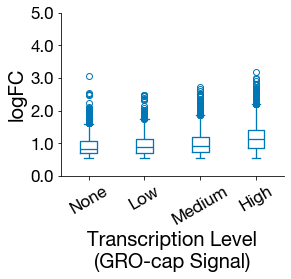

In [26]:
# Initialize plot canvas
fig = plt.figure(figsize=(4, 3))
ax = sns.boxplot(x="separate_GROcap_signal_levels", y="logFC", data=tmp,
                 log_scale=False, 
                 order=['none_transcription', 'low_transcription', 'medium_transcription', 'high_transcription'],
                 color='#0077b6', fill=False, linewidth=1.3, width=0.3)

# Set axis labels and limits
ax.set_xlabel('Transcription Level\n(GRO-cap Signal)', fontsize=20)
ax.set_ylabel('logFC', fontsize=20)
ax.set_ylim([0, 5])

# Format x-tick labels
ax.set_xticklabels(['None', 'Low', 'Medium', 'High'], rotation=30, fontsize=17)

# Format y-tick labels as percentages
y_ticks = ax.get_yticks().tolist()
y_tick_labels = [f"{tick:.1f}" for tick in y_ticks]
ax.set_yticklabels(y_tick_labels, fontsize=17)

# Remove chart border
sns.despine()